In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim

In [2]:
diabetes = load_diabetes()
data = diabetes.data
label = diabetes.target.reshape(-1,1)

print(f"data size: {data.shape}")
print(f"label size: {label.shape}")

data size: (442, 10)
label size: (442, 1)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2)
print(len(X_train), len(X_test))

353 89


In [4]:
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

In [5]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [6]:
train_batch = DataLoader(
    dataset=train_dataset,
    batch_size=20,
    shuffle=True,
    num_workers=0
)
test_batch = DataLoader(
    dataset=test_dataset,
    batch_size=20,
    shuffle=False,
    num_workers=0
)

for data, label in train_batch:
    print(f"batch data size: {data.size()}")
    print(f"batch label size: {label.size()}")
    break

batch data size: torch.Size([20, 10])
batch label size: torch.Size([20, 1])


In [7]:
class Net(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, H)
        self.linear3 = nn.Linear(H, D_out)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.linear3(x)
        return x

In [8]:
D_in = 10
H = 200
D_out = 1
epoch = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net(D_in, H, D_out).to(device)

In [9]:
criertion = nn.MSELoss()
criertion2 = nn.L1Loss()

optimizer = optim.Adam(net.parameters())

In [10]:
train_loss_list = []
test_loss_list = []
train_mae_list = []
test_mae_list = []

for i in range(epoch):
    if i % 10 == 0:
        print('-'*20)
        print(f"Epoch: {i+1}/{epoch}")

    train_loss = 0
    test_loss = 0
    train_mae = 0
    test_mae = 0

    net.train()
    for data, label in train_batch:
        data = data.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        y_pred = net(data)
        loss = criertion(y_pred, label)
        mae = criertion2(y_pred, label)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_mae += mae.item()

    batch_train_loss = train_loss / len(train_batch)
    batch_train_mae = train_mae / len(train_batch)

    # 評価モード　
    net.eval()
    # 自動微分機能をオフに
    with torch.no_grad():
        for data, label in test_dataset:
            data = data.to(device)
            label = label.to(device)
            y_pred = net(data)

            loss = criertion(y_pred, label)
            mae = criertion2(y_pred, label)

            test_loss += loss.item()
            test_mae += mae.item()

    batch_test_loss = test_loss / len(test_batch)
    batch_test_mae = test_mae / len(test_batch)
    if i % 10 == 0:
        print(f"Train_Loss: {round(batch_train_loss,4)}, {round(batch_train_mae,4)}")
        print(f"Test_Loss: {round(batch_test_loss,4)}, {round(batch_test_mae,4)}")

    train_loss_list.append(batch_train_loss)
    test_loss_list.append(batch_test_loss)
    train_mae_list.append(batch_train_mae)
    test_mae_list.append(batch_test_mae)


--------------------
Epoch: 1/100
Train_Loss: 28893.8043, 151.6066
Test_Loss: 489209.9952, 2607.4448
--------------------
Epoch: 11/100
Train_Loss: 4268.1734, 56.0036
Test_Loss: 52564.5423, 782.6659
--------------------
Epoch: 21/100
Train_Loss: 3446.2849, 47.3877
Test_Loss: 44398.7527, 712.7873
--------------------
Epoch: 31/100
Train_Loss: 3266.0749, 45.8266
Test_Loss: 44167.5075, 712.5689
--------------------
Epoch: 41/100
Train_Loss: 3210.9506, 45.3143
Test_Loss: 44114.8529, 712.9107
--------------------
Epoch: 51/100
Train_Loss: 2972.8365, 42.9644
Test_Loss: 44373.5515, 719.3668
--------------------
Epoch: 61/100
Train_Loss: 3051.9095, 44.3236
Test_Loss: 44693.3444, 724.4377
--------------------
Epoch: 71/100
Train_Loss: 3313.4885, 46.0758
Test_Loss: 45024.5518, 728.5899
--------------------
Epoch: 81/100
Train_Loss: 3042.3677, 44.0621
Test_Loss: 43602.8024, 714.7875
--------------------
Epoch: 91/100
Train_Loss: 3224.3647, 44.5278
Test_Loss: 43563.3161, 715.3568


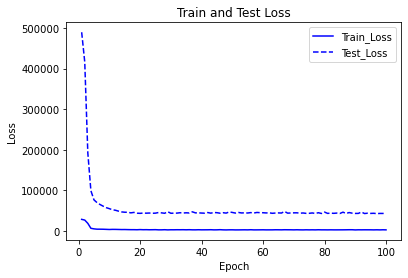

In [15]:
plt.figure()
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), train_loss_list, color='blue',
        linestyle='-', label='Train_Loss')
plt.plot(range(1, epoch+1), test_loss_list, color='blue',
        linestyle='--', label='Test_Loss')
plt.legend()

plt.figure()
plt.title('Train and Test MAE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), train_mae_list, color='blue',
        linestyle='-', label='Train_Loss')
plt.plot(range(1, epoch+1), test_mae_list, color='blue',
        linestyle='--', label='Test_Loss')
plt.legend()

plt.show()